In [4]:
import numpy as np
import pandas as pd
from backtesting import Strategy, Backtest
import joblib
import talib
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting.lib import crossover

In [5]:
def ema(arr, n=20):
    s = pd.Series(arr)
    return s.ewm(span=n, adjust=False).mean().values

def atr_high_low_close(high, low, close, n=14):
    h, l, c = pd.Series(high), pd.Series(low), pd.Series(close)
    prev_c = c.shift(1)
    tr = pd.concat([h - l, (h - prev_c).abs(), (l - prev_c).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean().values

def bars_per_year(tf="15m"):
    tf = str(tf).lower()
    if tf in ("15m", "m15", "15"):   return 365*24*4   # 35,040
    if tf in ("1h", "h1", "60m"):    return 365*24     # 8,760
    return 365                       # fallback (daily)

def sharpe_sortino_from_equity(eq, tf="15m"):
    rets = eq.pct_change().dropna()
    mu, sd = rets.mean(), rets.std()
    dd = rets[rets < 0].std()
    N = bars_per_year(tf)
    sharpe  = (mu/sd)*np.sqrt(N) if sd > 0 else 0.0
    sortino = (mu/dd)*np.sqrt(N) if dd > 0 else 0.0
    return float(sharpe), float(sortino)


In [6]:
class MASlopePullback(Strategy):
    ema_fast = 20
    ema_slow = 50
    atr_n = 14
    atr_k = 1.5     # SL distance multiplier
    cooldown = 3    # bars to wait after an entry
    
    def init(self):
        self.emaF = self.I(ema, self.data.Close, self.ema_fast)
        self.emaS = self.I(ema, self.data.Close, self.ema_slow)
        self.atr  = self.I(atr_high_low_close, self.data.High, self.data.Low, self.data.Close, self.atr_n)
        self._last_trade_bar = -1

    def next(self):
        i = len(self.data.Close) - 1
        if self._last_trade_bar != -1 and i - self._last_trade_bar < self.cooldown:
            return
        
        close, open_ = self.data.Close[-1], self.data.Open[-1]
        atr = self.atr[-1]
        if np.isnan(atr) or atr == 0:
            return
        
        # Regime by slope of slow EMA
        slope_up   = self.emaS[-1] > self.emaS[-2]
        slope_down = self.emaS[-1] < self.emaS[-2]

        # Pullback confirmation: price crosses back over fast EMA
        long_setup  = slope_up   and crossover(self.data.Close, self.emaF) and close > open_
        short_setup = slope_down and crossover(self.emaF, self.data.Close) and close < open_
        
        # Manage positions & entries with ATR stop
        if long_setup:
            if self.position.is_short: self.position.close()
            if not self.position.is_long:
                sl = close - self.atr_k * atr
                self.buy(sl=sl)
                self._last_trade_bar = i
        
        elif short_setup:
            if self.position.is_long: self.position.close()
            if not self.position.is_short:
                sl = close + self.atr_k * atr
                self.sell(sl=sl)
                self._last_trade_bar = i
        
        # Optional exit on regime flip
        if self.position.is_long and slope_down:
            self.position.close()
        if self.position.is_short and slope_up:
            self.position.close()


In [17]:
# Load data
datas = joblib.load('/home/dmin/CODE/BACKTEST/data/1h.joblib')
tickers = list(datas.keys())

# data: DataFrame gốc của bạn, có cột Date và ohlcv (có thể đang là chữ thường)

# 1) Đảm bảo index thời gian
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna(subset=['Date']).set_index('Date')

# 2) Đổi tên cột về đúng case và chọn đúng 5 cột
rename_map = {
    'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume',
    'Open':'Open', 'High':'High', 'Low':'Low', 'Close':'Close', 'Volume':'Volume'
}
data = data.rename(columns=rename_map)

# Nếu thiếu Volume thì thêm cột Volume = 0 (Backtesting bản bạn đang dùng đòi đủ 5 cột)
if 'Volume' not in data.columns:
    data['Volume'] = 0

data = data[['Open','High','Low','Close','Volume']].copy()

# 3) Ép kiểu số & loại NaN
for c in ['Open','High','Low','Close','Volume']:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data = data.dropna()
if data.empty:
    raise ValueError("Data trống sau khi chuẩn hoá. Kiểm tra lại nguồn dữ liệu.")

# 4) Gọi Backtest với DataFrame đã chuẩn
bt = Backtest(
    data,                # ⚠️ dùng 'data' đã chuẩn hoá, không phải 'df' cũ
    MASlopePullback,
    cash=100_000,
    commission=.0001,
    trade_on_close=True,
    exclusive_orders=True
)
stats = bt.run()  # hoặc bt.run(atr_k=..., cooldown=...)
bt.plot()
print(bt)

/tmp/ipykernel_398483/4276803902.py:33: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(
/home/dmin/CODE/venv/lib/python3.12/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '8h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/home/dmin/CODE/venv/lib/python3.12/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


In [19]:
# --- helpers: chuẩn hoá OHLCV + fallback sortino ---
import numpy as np, pandas as pd

def standardize_ohlcv(df):
    ren = {
        'date':'Date','time':'Date',
        'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume',
        'Open':'Open','High':'High','Low':'Low','Close':'Close','Volume':'Volume'
    }
    df = df.rename(columns={c: ren.get(c, c) for c in df.columns})
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')
        df = df.dropna(subset=['Date']).set_index('Date')
    # nếu index đã là datetime thì thôi; nếu không, cố ép:
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
    # chọn đúng cột, bổ sung Volume nếu thiếu
    need = ['Open','High','Low','Close']
    for c in need:
        if c not in df.columns:
            raise ValueError(f"Missing column {c}")
    if 'Volume' not in df.columns:
        df['Volume'] = 0
    df = df[['Open','High','Low','Close','Volume']].apply(pd.to_numeric, errors='coerce').dropna().sort_index()
    return df

def fallback_sortino(stats, periods_per_year=8760):
    eq = stats.get('_equity_curve', None)
    if eq is None: return np.nan
    ser = eq['Equity'].pct_change().dropna()
    if ser.empty: return np.nan
    mu = ser.mean()
    down = ser[ser < 0].std()
    if not np.isfinite(down) or down == 0: return np.nan
    return (mu / down) * np.sqrt(periods_per_year)

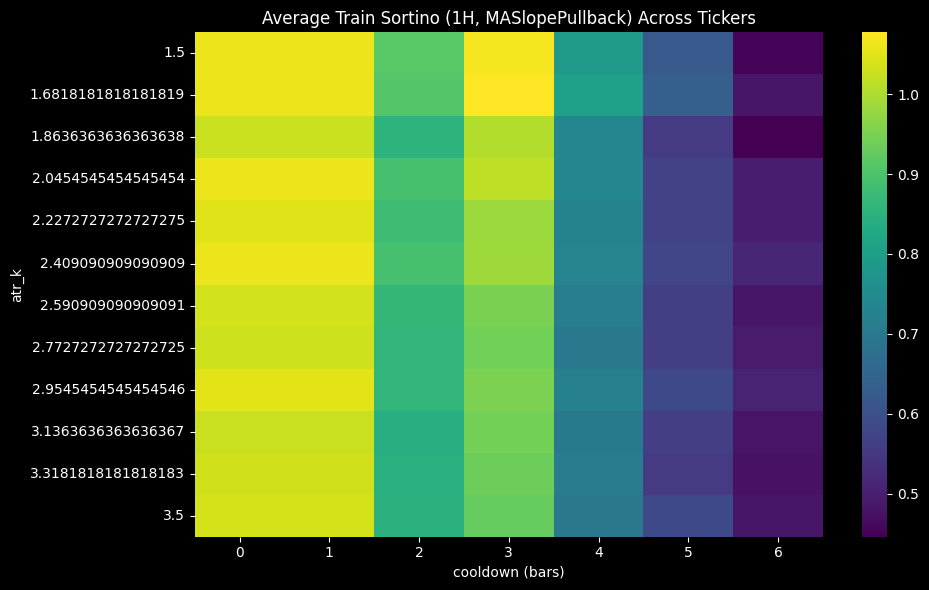


Averaged params → atr_k: 1.61, cooldown: 1


In [20]:
# === SWEEP cho 1H: MASlopePullback với atr_k (multi) & cooldown (thresholds) ===
import joblib, matplotlib.pyplot as plt, seaborn as sns
from backtesting import Backtest

datas = joblib.load('/home/dmin/CODE/BACKTEST/data/1h.joblib')

train_ratio = 0.7
multi = np.linspace(1.5, 3.5, 12)             # -> atr_k
thresholds = np.arange(0, 7, 1, dtype=int)    # -> cooldown
PPY = 8760                                     # 1h

sweep_results = []
i = 0

for ticker, raw in datas.items():
    i += 1
    if i > 10: break
    if ticker == 'XLMUSDT': continue

    try:
        data = standardize_ohlcv(raw.copy())
    except Exception as e:
        print(f"[{ticker}] skip due to format: {e}")
        continue

    # đủ dữ liệu (30k bar 1h ~ 3.4 năm)
    if len(data) <= 30000:
        # nếu dataset 1h ngắn, hạ ngưỡng để không bỏ lỡ
        if len(data) <= 5000:
            print(f"[{ticker}] too short: {len(data)} bars"); 
            continue

    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx].copy()

    for m in multi:
        for th in thresholds:
            bt_train = Backtest(train_data, MASlopePullback,
                                cash=1_000_000_000,  # tránh fractional
                                commission=.0002,    # 0.02%/side ví dụ futures
                                trade_on_close=True,
                                exclusive_orders=True)
            stats = bt_train.run(atr_k=float(m), cooldown=int(th))
            sortino = stats.get('Sortino Ratio', np.nan)
            if np.isnan(sortino):
                sortino = fallback_sortino(stats, periods_per_year=PPY)
            sweep_results.append((m, th, sortino, ticker))

# --- aggregate & heatmap ---
df_sweep = pd.DataFrame(sweep_results, columns=['Multi','Threshold','Sharpe','Ticker'])
avg_sweep = (df_sweep
             .dropna(subset=['Sharpe'])
             .groupby(['Multi','Threshold'])['Sharpe']
             .mean().reset_index())

pivot = avg_sweep.pivot(index='Multi', columns='Threshold', values='Sharpe')

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=False)
plt.title("Average Train Sortino (1H, MASlopePullback) Across Tickers")
plt.xlabel("cooldown (bars)")
plt.ylabel("atr_k")
plt.tight_layout()
plt.show()

top5 = avg_sweep.nlargest(5, 'Sharpe')
best_multi = float(top5['Multi'].mean())
best_threshold = int(round(top5['Threshold'].mean()))
print(f"\nAveraged params → atr_k: {best_multi:.2f}, cooldown: {best_threshold}")


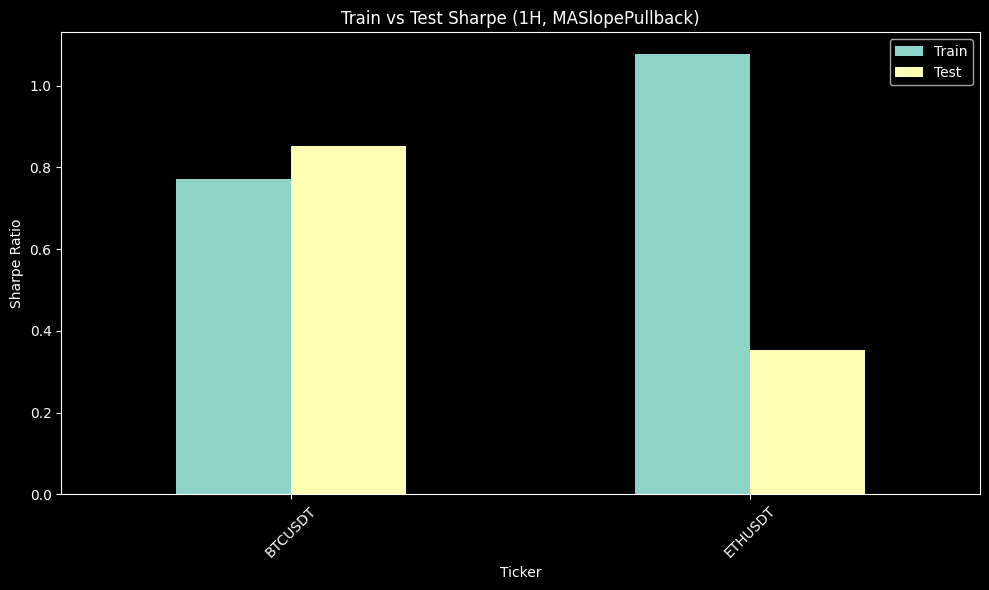

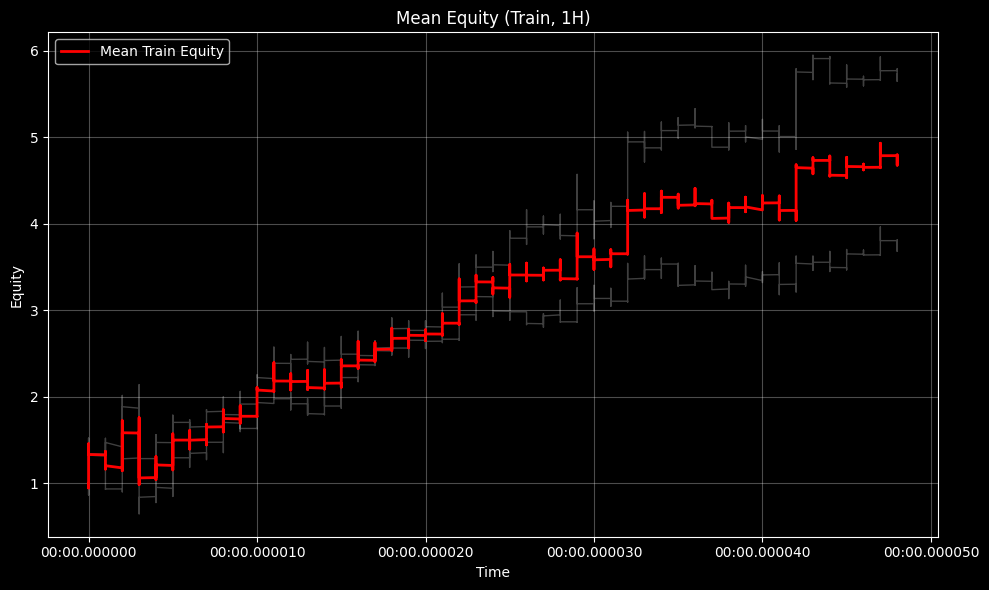

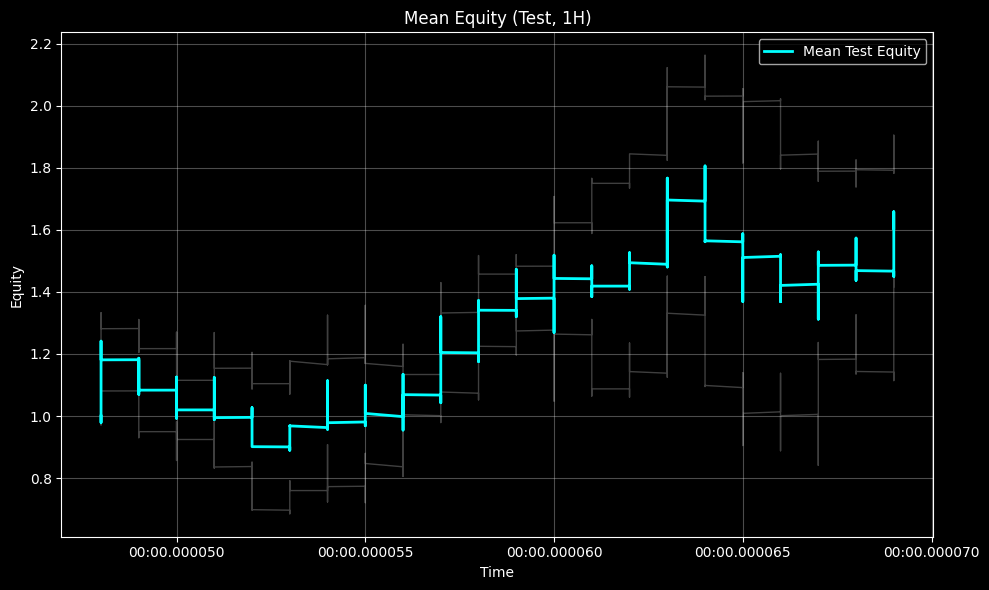

In [24]:
PPY = 8760  # 1h

def standardize_ohlcv(df):
    ren = {'date':'Date','time':'Date',
           'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume',
           'Open':'Open','High':'High','Low':'Low','Close':'Close','Volume':'Volume'}
    df = df.rename(columns={c: ren.get(c, c) for c in df.columns})
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')
        df = df.dropna(subset=['Date']).set_index('Date')
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True, errors='coerce')
    if 'Volume' not in df.columns:
        df['Volume'] = 0
    df = df[['Open','High','Low','Close','Volume']].apply(pd.to_numeric, errors='coerce').dropna().sort_index()
    return df

def fallback_sharpe_from_equity(stats, periods_per_year=PPY):
    eq = stats.get('_equity_curve', None)
    if eq is None or '_equity_curve' not in stats:
        return np.nan
    rets = eq['Equity'].pct_change().dropna()
    if rets.empty:
        return np.nan
    mu = rets.mean()
    sd = rets.std()
    if not np.isfinite(sd) or sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)

# === Step 5: Run train/test với best params (atr_k, cooldown) ===
train_results, test_results = {}, {}
train_equities, test_equities = {}, {}
skipped = []

i = 0
for ticker, raw in datas.items():
    if ticker == 'XLMUSDT':
        continue
    i += 1
    if i > 10:
        break

    try:
        data = standardize_ohlcv(raw.copy())
    except Exception as e:
        skipped.append((ticker, f"format error: {e}"))
        continue

    if len(data) <= 5000:
        skipped.append((ticker, f"too short: {len(data)} bars"))
        continue

    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx].copy()
    test_data  = data.iloc[split_idx:].copy()

    # Train
    bt_train = Backtest(train_data, MASlopePullback,
                        cash=1_000_000_000, commission=.0002,
                        trade_on_close=True, exclusive_orders=True)
    st_tr = bt_train.run(atr_k=float(best_multi), cooldown=int(best_threshold))

    sharpe_tr = st_tr.get('Sharpe Ratio', np.nan)
    if np.isnan(sharpe_tr):
        sharpe_tr = fallback_sharpe_from_equity(st_tr, PPY)

    # Bỏ qua nếu vẫn NaN (không có lệnh)
    if not np.isfinite(sharpe_tr):
        skipped.append((ticker, "no trades or NaN Sharpe (train)"))
        continue

    train_results[ticker]  = sharpe_tr
    train_equities[ticker] = st_tr['_equity_curve']['Equity'].pct_change().cumsum() + 1

    # Test
    bt_test = Backtest(test_data, MASlopePullback,
                       cash=1_000_000_000, commission=.0002,
                       trade_on_close=True, exclusive_orders=True)
    st_te = bt_test.run(atr_k=float(best_multi), cooldown=int(best_threshold))

    sharpe_te = st_te.get('Sharpe Ratio', np.nan)
    if np.isnan(sharpe_te):
        sharpe_te = fallback_sharpe_from_equity(st_te, PPY)

    if not np.isfinite(sharpe_te):
        skipped.append((ticker, "no trades or NaN Sharpe (test)"))
        # vẫn giữ train, nhưng test sẽ vắng; tùy bạn có muốn continue hay không
        # continue

    test_results[ticker]  = sharpe_te
    test_equities[ticker] = st_te['_equity_curve']['Equity'].pct_change().cumsum() + 1

# === Step 6: Plot bar chart Train vs Test nếu có dữ liệu ===
df_results = pd.DataFrame({
    "Train": pd.Series(train_results),
    "Test":  pd.Series(test_results)
}).dropna(how="all")

if df_results.empty:
    print("⚠️ Không có dữ liệu để vẽ bar chart (df_results rỗng).")
    if skipped:
        print("Skipped tickers & reasons:")
        for tkr, why in skipped[:20]:
            print(f" - {tkr}: {why}")
else:
    ax = df_results.plot(kind='bar', figsize=(10,6),
                         title="Train vs Test Sharpe (1H, MASlopePullback)")
    ax.set_ylabel("Sharpe Ratio")
    ax.set_xlabel("Ticker")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Equity curves (vẽ nếu có) ===
df_train_eq = pd.DataFrame(train_equities).dropna(how="any")
df_test_eq  = pd.DataFrame(test_equities).dropna(how="any")

if not df_train_eq.empty:
    mean_train = df_train_eq.mean(axis=1)
    plt.figure(figsize=(10,6))
    for c in df_train_eq.columns:
        plt.plot(df_train_eq[c], color='white', alpha=0.25, linewidth=1, label='_nolegend_')
    plt.plot(mean_train, color='red', linewidth=2, label='Mean Train Equity')
    plt.title("Mean Equity (Train, 1H)")
    plt.xlabel("Time"); plt.ylabel("Equity"); plt.legend()
    plt.gca().set_facecolor('black'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("⚠️ Không có equity train để vẽ.")

if not df_test_eq.empty:
    mean_test = df_test_eq.mean(axis=1)
    plt.figure(figsize=(10,6))
    for c in df_test_eq.columns:
        plt.plot(df_test_eq[c], color='white', alpha=0.25, linewidth=1, label='_nolegend_')
    plt.plot(mean_test, color='cyan', linewidth=2, label='Mean Test Equity')
    plt.title("Mean Equity (Test, 1H)")
    plt.xlabel("Time"); plt.ylabel("Equity"); plt.legend()
    plt.gca().set_facecolor('black'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
else:
    print("⚠️ Không có equity test để vẽ.")

# Báo cáo tóm tắt skip (nếu có)
if skipped:
    print("\nSkipped summary (first 20):")
    for tkr, why in skipped[:20]:
        print(f" - {tkr}: {why}")

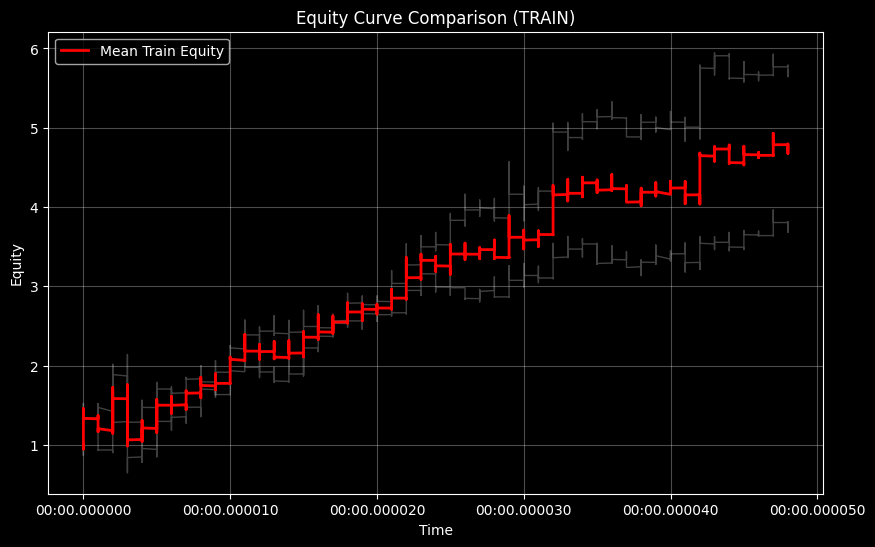

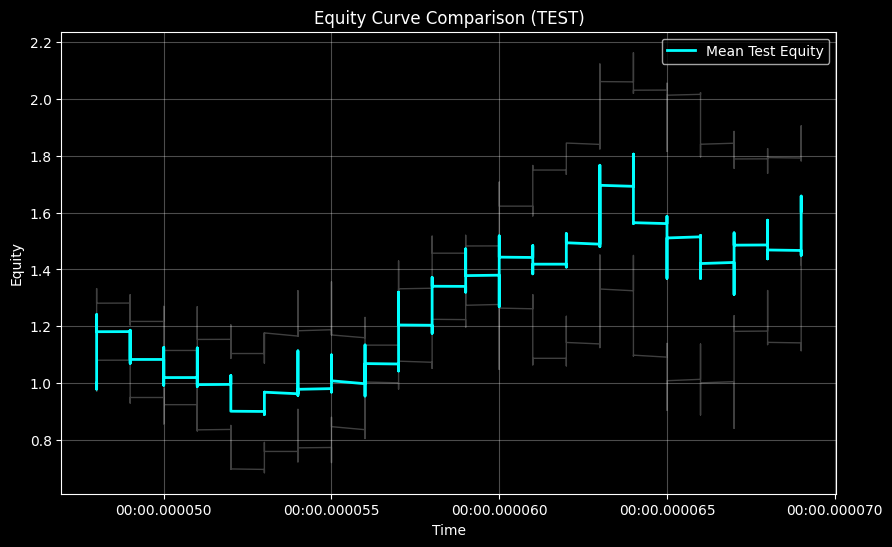

=== TRAIN metrics ===


,CAR,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
BTCUSDT,1.615996,0.651074,1.477044,-0.452889,3.568195
ETHUSDT,2.518910,0.901461,1.395709,-0.599494,4.201724



Mean (TRAIN):


CAR             2.067453
Volatility      0.776267
Sharpe Ratio    1.436376
Max Drawdown   -0.526192
Calmar Ratio    3.884960
dtype: float64


=== TEST metrics ===


,CAR,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
BTCUSDT,1.673998,0.539370,1.823651,-0.231636,7.226840
ETHUSDT,0.793866,0.932134,0.626950,-0.424488,1.870172



Mean (TEST):


CAR             1.233932
Volatility      0.735752
Sharpe Ratio    1.225301
Max Drawdown   -0.328062
Calmar Ratio    4.548506
dtype: float64

In [25]:
# =========================
# Step 7: Plot equity curves (Train & Test) và tính metrics
# =========================

# Gộp equity (đÃ là đường cong vốn hoá, KHÔNG tính lại pct_change ở đây)
df_train = pd.DataFrame(train_equities).dropna(how="any")
df_test  = pd.DataFrame(test_equities).dropna(how="any")

# Mean equity
mean_train_equity = df_train.mean(axis=1)
mean_test_equity  = df_test.mean(axis=1) if not df_test.empty else None

# ----- Plot TRAIN -----
plt.figure(figsize=(10, 6))
for col in df_train.columns:
    plt.plot(df_train[col], color='white', alpha=0.25, linewidth=1, label='_nolegend_')
plt.plot(mean_train_equity, color='red', linewidth=2, label='Mean Train Equity')

plt.title("Equity Curve Comparison (TRAIN)")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().set_facecolor('black')
plt.show()

# ----- Plot TEST (nếu có) -----
if not df_test.empty:
    plt.figure(figsize=(10, 6))
    for col in df_test.columns:
        plt.plot(df_test[col], color='white', alpha=0.25, linewidth=1, label='_nolegend_')
    plt.plot(mean_test_equity, color='cyan', linewidth=2, label='Mean Test Equity')

    plt.title("Equity Curve Comparison (TEST)")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().set_facecolor('black')
    plt.show()

# =========================
# Metrics theo timeframe
# =========================
def _periods_per_year(tf="15m"):
    tf = str(tf).lower()
    if tf in ("15m", "m15", "15"): return 365*24*4      # 35,040
    if tf in ("1h", "h1", "60m", "60"): return 365*24   # 8,760
    return 365

PPY = _periods_per_year(TIMEFRAME) if 'TIMEFRAME' in globals() else 365*24*4

from utils import performance_metrics

# Metrics cho TRAIN
train_metrics = {}
for tkr in df_train.columns:
    train_metrics[tkr] = performance_metrics(df_train[tkr], periods_per_year=PPY)

train_metrics_df = pd.DataFrame(train_metrics).T
print("=== TRAIN metrics ===")
display(train_metrics_df)
print("\nMean (TRAIN):")
display(train_metrics_df.mean(numeric_only=True))

# Metrics cho TEST (nếu có)
if not df_test.empty:
    test_metrics = {}
    for tkr in df_test.columns:
        test_metrics[tkr] = performance_metrics(df_test[tkr], periods_per_year=PPY)

    test_metrics_df = pd.DataFrame(test_metrics).T
    print("\n=== TEST metrics ===")
    display(test_metrics_df)
    print("\nMean (TEST):")
    display(test_metrics_df.mean(numeric_only=True))
